# REINFORCEMENT LEARNING

### Author: Hyungjoo Kim

##### All data was provided by University College London, Department of Computer Science, Reinforcement Learning Module

##### Supervisor: Prof. Hado Van Hasselt, Matteo Hessel, and Diana Borsa

# Setup

### Import Useful Libraries

In [4]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Gridworlds

In [5]:
#@title Implementation
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap="YlOrRd_r")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-3):
      plt.plot([+0.5, w-1.5], [y+1.5, y+1.5], '-k', lw=2, alpha=0.5)
    for x in range(w-3):
      plt.plot([x+1.5, x+1.5], [+0.5, h-1.5], '-k', lw=2, alpha=0.5)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()
  
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

A grid world


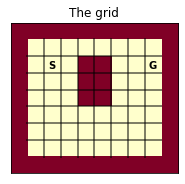


An alternative grid world


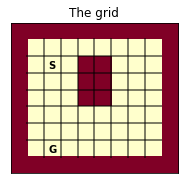


Features (visualised as 9x9 heatmaps) for different locations in the grid
(Note: includes unreachable states that coincide with walls in this visualisation.)


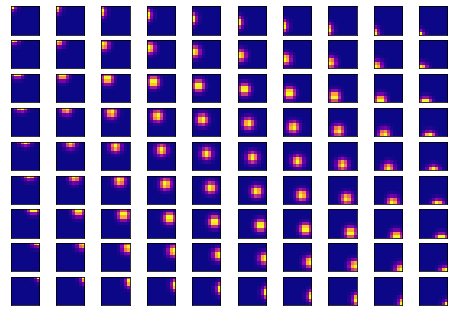

In [6]:
#@title Show gridworlds

# Plot tabular environments
grid = Grid()
alt_grid = AltGrid()
print("A grid world")
grid.plot_grid()
plt.show()
print("\nAn alternative grid world")
alt_grid.plot_grid()
plt.show()

# Plot features of each state for non tabular version of the environment.
print(
    "\nFeatures (visualised as 9x9 heatmaps) for different locations in the grid"
    "\n(Note: includes unreachable states that coincide with walls in this visualisation.)"
)
feat_grid = FeatureGrid()
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)),
            interpolation='nearest',
            cmap='plasma')
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [26]:
#@title helper functions (run, but don't modify this cell)

def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

# Part 1: Planning 
You will implement several algorithms to investigate the role of planning in reinforcement learning.

## 1.1: Implement Models

### Q 1.1.1 

Implement a trainable **tabular model** of the environment.

The model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model predictions.

Given that the environment is deterministic and tabular the model will reduce to a simple lookup table.

In [8]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    # Initialise a state, reward, and discount using the input (the number of states and the number of actions)
    self.State = np.zeros((number_of_states, number_of_actions), dtype = 'int8')
    self.Reward = np.zeros((number_of_states, number_of_actions), dtype = 'float32')
    self.Discount = np.zeros((number_of_states, number_of_actions), dtype = 'float32')
    return

  def next_state(self, s, a):
    return self.State[s, a]
  
  def reward(self, s, a):
    return self.Reward[s, a]

  def discount(self, s, a):
    return self.Discount[s, a]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    self.State[state, action] = next_state
    self.Reward[state, action] = reward
    self.Discount[state, action] = discount
    return

### Q 1.1.2 

Implement a trainable **linear model** of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward $r'$, discount $\gamma'$ and next state $\mathbf{s}'$ will all be a linear function of the current state $\mathbf{s}$.
* $\mathbf{s}' = \mathbf{M}_a \mathbf{s}$
* $r' = (\mathbf{m}^r_a)^{\top} \mathbf{s}$
* $\gamma' = (\mathbf{m}^{\gamma}_a)^{\top} \mathbf{s}$

Where $\mathbf{M}_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $\mathbf{m}^r_a$ and $\mathbf{m}^{\gamma}_a$ are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by stochastic gradient descent. 

Write down the update to the parameters of the models and implement the update in the model below.


In [9]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self._transition = np.zeros((number_of_actions, number_of_features, number_of_features), dtype = 'float32')
    self._reward = np.zeros((number_of_actions, number_of_features), dtype = 'float32')
    self._discount = np.zeros((number_of_actions, number_of_features), dtype = 'float32')

  def next_state(self, s, a):
    M_a = self._transition[a, :, :]
    next_State = np.matmul(M_a, s)
    return next_State
  
  def reward(self, s, a):
    m_r_a = self._reward[a, :]
    predicted_reward = np.matmul(m_r_a, s)
    return predicted_reward

  def discount(self, s, a):
    m_gamma_a = self._discount[a, :]
    predicted_discount = np.matmul(m_gamma_a, s)
    return predicted_discount

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    self._transition[action, :, :] += step_size * np.matmul((next_state - self.next_state(state, action)).reshape(-1, 1), state.reshape(1, -1))
    self._reward[action, :] += step_size * (reward - self.reward(state, action)) * state
    self._discount[action, :] += step_size * (discount - self.discount(state, action)) * state
    return

## 1.2: Implement Agents

We are going to implement 4 agent:
- Tabular Q-learning with Experience Replay
- Tabular Dyna-Q with a tabular model
- Linear Q-learning with Experience Replay
- Linear Dyna-Q with a linear model

All agents you implement in this section must share the agent interface below:

#### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get such initial observation by instatiating an environment (e.g., `grid = Grid()`), and then calling `grid.get_obs()`.

#### `step(self, reward, discount, next_observation)`:
The step should update the internal values, and return a new action to take. When the discount is zero ($\text{discount} = \gamma = 0$), the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function. Note that to perform updates within the `step` function you typically need to store the previous state and/or action: you may set such previous action to 0 in the constructor for consumption in the first step of the first episode of the agent's lifetime.
 
#### `q_values()`:
For tabular agents **only**. This method must return a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

#### `q_values(state)`:
For agents with function approximation **only**. This method must return an array of Q values of shape: (`number_of_actions`)


### Q 1.2.1 

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate each observed transition *(s, a, r, g, s')* in a *replay buffer*,
* apply an online Q-learning update with the most recently observed transition,
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

So, the `step` function of the agent will, conceptually, look as follows:

1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ 

1. Loop repeat n times:

  1. Sample $S, A, R, \gamma, S'$ from replay
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [10]:
 class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self._q_value = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._behaviour_policy = behaviour_policy
    self._updates = num_offline_updates
    self._step_size = step_size
    self._action = 0
    self._replay_buffer = []
    self.number_of_actions = number_of_actions
    return
    
  @property
  def q_values(self):
    return self._q_value

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state  
    
    # 1. Append most recent observed transition (s, a, r, g, next_s) to replay buffer
    self._replay_buffer.append((s, a, r, g, next_state))
    
    # 2. Update values with Q-learning, using transition (s, a, r, g, next_s)
    self._q_value[s, a] += self._step_size * (r + g * np.max(self._q_value[next_s]) - self._q_value[s, a])
    
    # Use floor function to make integer
    sample_index = np.floor((len(self._replay_buffer) * np.random.rand(self._updates)))
    # 3. Loop repeat n times
    for n in range(len(sample_index)):
        # 3.A Sample (s, a, r, g, next_s) from replay
        replay_s, replay_a, replay_r, replay_g, replay_next_s = self._replay_buffer[(int)(sample_index[n])]
        # 3.B Update values with Q-learning, using transition (s, a, r, g, next_s)
        self._q_value[replay_s, replay_a] += self._step_size * (replay_r + replay_g * np.max(self._q_value[replay_next_s]) - self._q_value[replay_s, replay_a])
    
    # Return the action and state
    self._action = self._behaviour_policy(self._q_value[next_s])
    self._state = next_s
    return self._action


### Q 1.2.2

Implement an agent that uses **Dyna-Q** to learn action values.
* select actions randomly
* accumulate all observed transitions *(s, a)* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

So, the `step` function conceptually looks as follows:
1. Append most recent observed transition $(S_t, A_t)$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Update model: $M(S_t, A_t)$, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Loop repeat n times:

  1. Sample $S, A$ from replay
  
  1. Generate $R, \gamma, S' = M(S, A)$
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [11]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q_value = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._behaviour_policy = behaviour_policy
    self._updates = num_offline_updates
    self._step_size = step_size
    self._action = 0
    self._replay_buffer = []
    self._model = TabularModel(number_of_states, number_of_actions)
    self.number_of_actions = number_of_actions
    return
    
  @property
  def q_values(self):
    return self._q_value

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # 1. Append the most recent observed transition (state and action) to replay buffer
    self._replay_buffer.append((s, a))
    # 2. Update values with Q-learning, using transition (s, a, r, g, next_s)
    self._q_value[s, a] += self._step_size * (r + g * np.max(self._q_value[next_s]) - self._q_value[s, a])
    # 3. Update model a transition matrix from a LindearModel using transition (s, a, r, g, next_s)
    self._model.update(s, a, r, g, next_s)
    
    # Use floor function to make integer
    sample_index = np.floor((len(self._replay_buffer) * np.random.rand(self._updates)))
    # 4. Loop repeat 'n' times
    for n in range(self._updates):
        # 4.A Sample the state and action from replay buffer
        replay_s, replay_a = self._replay_buffer[(int)(sample_index[n])]
        # 4.B Generate replay reward, discount and next state to the transition from the LinearModel
        replay_r, replay_g, replay_next_s = self._model.transition(replay_s, replay_a)
        # 4.C Update values with Q-learning, using transition (s, a, r, g, next_s)
        self._q_value[replay_s, replay_a] += self._step_size * (replay_r + replay_g * np.max(self._q_value[replay_next_s]) - self._q_value[replay_s, replay_a])
    
    # Return the action and state
    self._action = self._behaviour_policy(self._q_value[next_s])
    self._state = next_s
    return self._action

### Q 1.2.3 

Implement an agent that uses **Experience Replay** to learn action values as a **linear function approximation** over a given set of features.

Learn the value estimates via online stochastic gradient descent.  The observed `state` will now be a vector of length `number_of_features`, and the value estimate will be $w_t^\top x_t$, where $w_t$ are the current weights and $x_t$ is the observed (agent) state at time $t$.

In [12]:
class LinearExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(LinearExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self._transition = np.zeros((number_of_actions, number_of_features), dtype = 'float32')
    return 

  def q(self, state):
    return np.matmul(self._transition, state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # 1. Append the most recent observed transition (s, a, r, g, next_s) to replay buffer
    self._replay_buffer.append((s, a, r, g, next_s))
    # 2. Update transition with Q-learning, using the transition (s, a, r, g, next_s)
    self._transition[a, :] += self._step_size * (r + g * np.max(np.matmul(self._transition, next_s)) - np.matmul(self._transition, s)[a]) * s
    
    # Use floor function to make integer
    sample_index = np.floor((len(self._replay_buffer) * np.random.rand(self._updates)))
    # 3. Loop repeat 'n' times
    for n in range(self._updates):
        # 3.A Sample the transition (s, a, r, g, next_s) from replay buffer
        replay_s, replay_a, replay_r, replay_g, replay_next_s = self._replay_buffer[(int)(sample_index[n])]
        # 3.B Update the transition (s, a, r, g, next_s) with Q-learning
        self._transition[replay_a, :] += self._step_size * (replay_r + replay_g * np.max(np.matmul(self._transition, replay_next_s)) - np.matmul(self._transition, replay_s)[replay_a]) * replay_s
    
    # Return the action and state
    self._action = self._behaviour_policy(np.matmul(self._transition, next_s))
    self._state = next_s
    return self._action

### Q 1.2.4 

Implement an agent that uses **Dyna-Q** that uses a **linear function approximation** to represent values as well as for the model of the environment.

Represent and learn both the **transition model** and the **reward model** as linear, action-dependent transformations of the given set of features.  The transition and reward models should be represented separately.  Implement separate models for each action (instead of, e.g., passing a one-hot identifier of the action in).

Learn value estimates, transition model and reward model via online stochastic gradient descent.

In [13]:
class LinearDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, model_step_size=0.1,
               *args, **kwargs):
    super(LinearDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self._transition = np.zeros((number_of_actions, number_of_features), dtype = 'float32')
    self._model = LinearModel(number_of_features, number_of_actions)
    return

  def q(self, state):
    return np.matmul(self._transition, state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # 1. Append the most recent observed transition (s, a) to replay buffer
    self._replay_buffer.append((s, a))
    # 2. Update transition with Q-learning, using the transition (s, a)
    self._transition[a, :] += self._step_size * (r + g * np.max(np.matmul(self._transition, next_s)) - np.matmul(self._transition, s)[a]) * s
    # 3. Update model with linear function approximation from a LinearModel using transition (s, a, r, g, next_s, step_size)
    self._model.update(s, a, r, g, next_s, self._step_size)
    
    # Use floor function to make integer
    sample_index = np.floor((len(self._replay_buffer) * np.random.rand(self._updates)))
    # 4. Loop repeat 'n' times
    for n in range(self._updates):
        # 4.A Sample the state and action from replay buffer
        replay_s, replay_a = self._replay_buffer[(int)(sample_index[n])]
        # 4.B Generate replay reward, discount and next state to the transition from the LinearModel
        replay_r, replay_g, replay_next_s = self._model.transition(replay_s, replay_a)
        # 4.C Update the transition (s, a, r, g, next_s) with Q-learning
        self._transition[replay_a, :] += self._step_size * (replay_r + replay_g * np.max(np.matmul(self._transition, replay_next_s)) - np.matmul(self._transition, replay_s)[replay_a]) * replay_s
        
    # Return the action and state
    self._action = self._behaviour_policy(np.matmul(self._transition, next_s))
    self._state = next_s
    return self._action

## 1.3: Analyse Results

You will have to analyse experiments that evaluate each of these 5 agents in various settings, and in terms of different metrics.

- Tabular learning: data efficiency
- Tabular learning: computational efficiency
- Linear function approximation
- Learning in non-stationary environments

### Run data efficiency experiments

*Online Q-learning*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $0$

*Experience Replay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

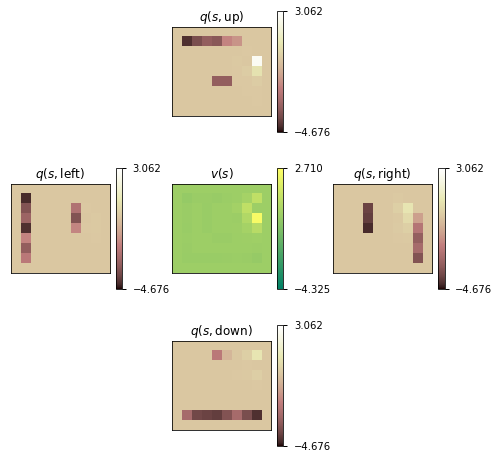

In [14]:
# Online Q
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

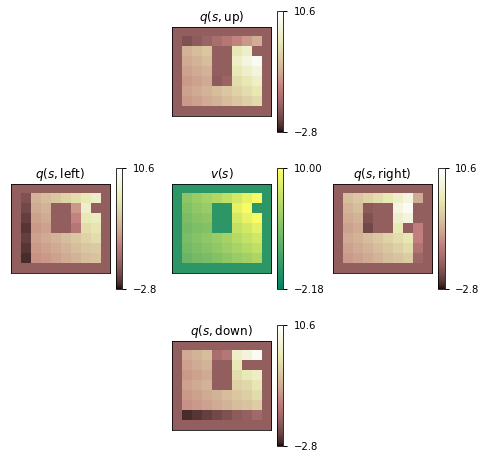

In [15]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

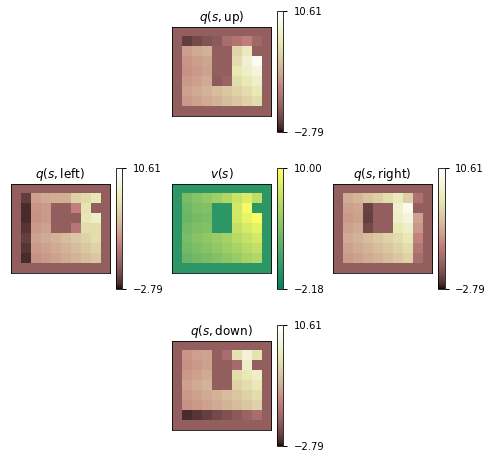

In [16]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Q 1.3.1

In the experiments above, how do the learnt value estimates differ between the online Q-learning, ExperienceReplay, and Dyna Q agents?

Explain meaningful differences in at most 5 sentences.

> The value estimates of the online Q-learning agent represents significantly different compared to the ExperienceReplay and Dyna Q agents because the agent in online Q-learning does not utilise the planning to learn the model, which results in the action values are the same. Only the last step is applied to learning since each policy only updates each episode that corresponds to each step, therefore the $v(s)$ in the online Q-learning represents equally except for the right side of the top corner. The value estimate of the ExperienceReplay agent provokes continuous updates, which reduces the variance of updates so that the data utilisation of the ExperienceReplay agent is extremely efficient than the online Q-learning agent as shown in the above figures. On the other hand, the Dyna Q agent allows faster convergence and looks more efficient than the online Q-learning agent because of the large number of offline updates and also updating its model (explain this meaning in the next sentence). Furthermore, the Dyna Q and ExperienceReplay agents look significantly similar but slightly different because the structures of their algorithms are similar except for the Dyna Q updates its model, which generates the reward ($R$) and next state ($S^{'}$) from the transition matrix ($M(S, A)$) at the latest transition.

### Run experiments matching computational cost

*Online Q-learning*

* $\text{number_of_steps}$ = $62,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

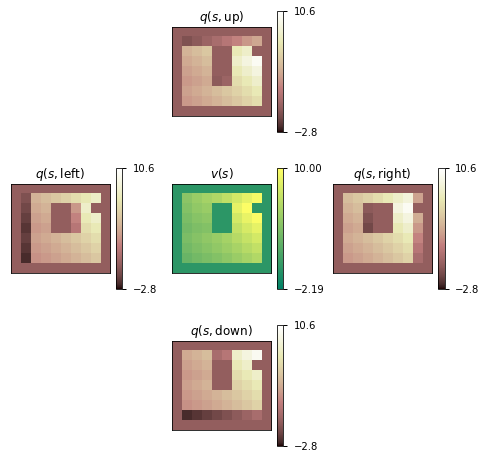

In [17]:
# OnlineQ
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(62e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

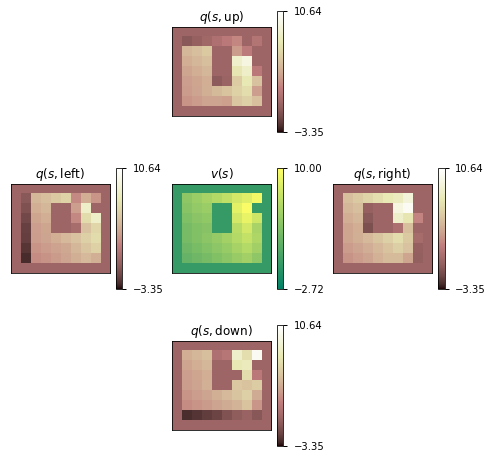

In [18]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

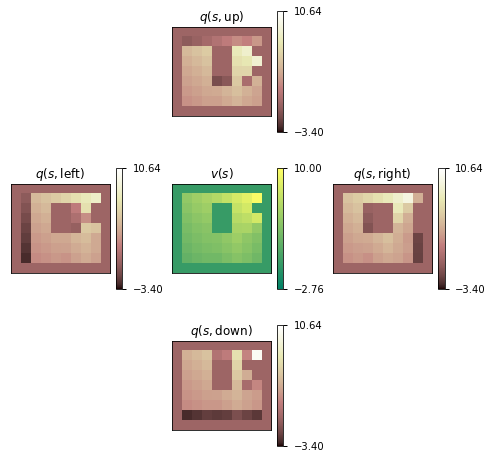

In [19]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

What if sampling from the environment is cheap and we don't care about data efficiency but only care about the amount of computation we use? 

The experiments directly above are the same as those above question 1.3.1, except that we ran the experiments for the same number of **total updates**, rather than the same number of **steps in the environment**, therefore using more data for the online Q-learning algorithm which *only* updates from real data.

### Q 1.3.2

How do the learnt values, and the relative performances, change, compared to the experiment above question 1.3.1?  Explain in at most 5 sentences.

> The performance of the online Q-learning agent is significantly improved when it compares to the result from Question 1.3.1 because the agent was run the more number of steps and did not care about the data efficiency anymore, therefore the agent uses more data, which interacted with the real data. The number of steps and the number of offline updates in ExperienceReplay and Dyna Q agents are fixed to 2000 and 30, respectively (same conditions as Question 1.3.1).  The performance of these agents looks worse than the online Q-learning agent in the above figures. This is because the online Q-learning runs more steps (good) and the ExperienceReplay agent stays a long time in the buffer, which results in a potentially biased offline update that can lead to minor distortions. Furthermore, the Dyna Q agent is performing with an updated model from the transition matrix so that it also occurs biased because of the same principle as the ExperienceReplay agent.

### Run experiments with linear function approximation

We will now use the $\text{FeatureGrid}$ domain, and consider the same 3 algorithms in the context of linear function approximation.

*Online Q-learning*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

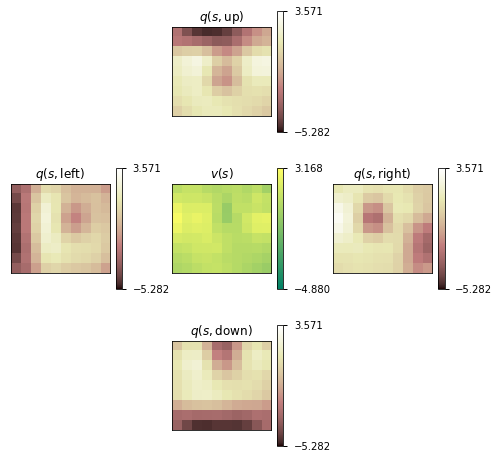

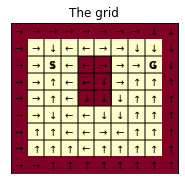

In [20]:
# OnlineQ
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

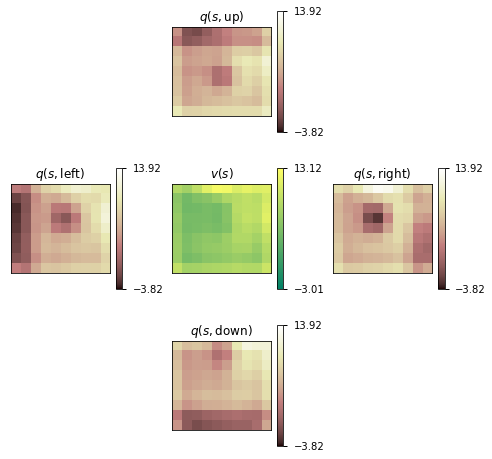

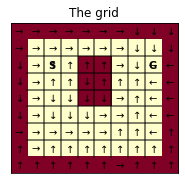

In [21]:
# Experience Replay
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

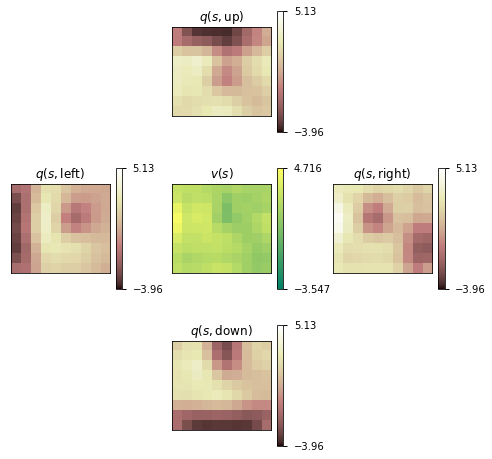

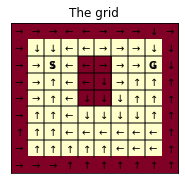

In [22]:
# LinearDynaQ
grid = FeatureGrid()

agent = LinearDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

### Q 1.3.3 

How do the value estimates learnt with function approximation differ from those learnt in the tabular setting, as in the experiment above question 1.3.2?

Explain the results in at most 5 sentences.

> The figures from those agents with linear function approximation represent that they seem to be brighter and blurry than the tabular setting figures although the number of steps is applied more. It means that the agents with linear function approximation cannot properly distinguish a wall from the other states. This is because the agents of linear function approximation are updated all parameters in the state-action pair, including the other states.  Therefore, $v(s)$ with linear function approximation has a significantly similar colour, but it looks blurry. 

### Q 1.3.4 

Inspect the policies derived by training agents with linear function approximation on `FeatureGrid'. 

How do they compare to the optimal policy?

> The online Q-learning agent with linear function approximation might have a troubling issue between the states (ㅣ->ㅣ<-ㅣ) in the bottom-middle side as shown in the grid figure. It means that the agent can be possible moving only between two states when it reaches the area and would finally occur stuck. Furthermore, all agents (online Q-learning, ExperienceReplay, and Dyna Q) with linear function approximation cannot properly distinguish the wall and looks blurry as shown in $v(s)$ figures. This is because the walls cannot be defined accurately from the other states with linear function approximation while updating all parameters as mentioned in the previous question. Therefore, we can argue that all agents with linear function approximation are worse than the optimal policy.

### Run experiments in a non stationary environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left - refer to "Show gridworlds"). The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

*Online Q-learning*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$, and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

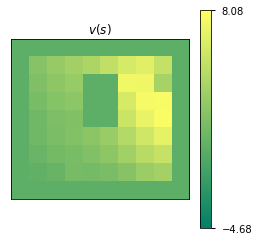

In [23]:
# Online Q

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

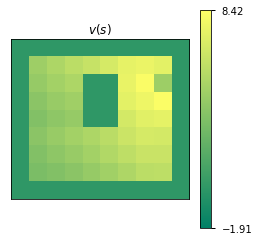

In [24]:
# Experience Replay

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

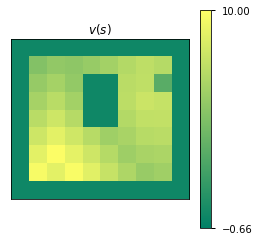

In [25]:
# DynaQ

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

### Q 1.3.5 

Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location. 

Explain what you see in at most 5 sentences. 

> In the online Q-learning agent figure, the wall looks brighter and not smoother overall than the Dyna Q agent's figure. This is because the online Q-learning agent tries to find some change environment out which means that the agent tries to interact with the changing environment to find a new algorithm and a new goal. 
On the other hand, the Dyna Q is a representative planning algorithm and the agent only updates $Q(s, a)$ for the states that have actually been visited and have been performed in that states, using recent observation states and actions to get reward and next state. Furthermore, the Dyna Q model is not trusted for unvisited states and actions not performed, so the planning allows learning much faster and efficient way because of some fixed policy. Therefore, the Dyna Q agent performs better than the online Q-learning agent, and the online Q-learning performance can be better than before if the number of steps is increased, even can converge.

### Q 1.3.6 

Compare the value estimates of online Experience Replay and Dyna-Q, after training also on the new goal location.

Explain what you see in at most 5 sentences. 

> The value estimate $v(s)$ of the ExperienceReplay seems almost similar to before and after the environment changes, which means that the ExperienceReplay agent could not much realise the changing environment. In this case, the ExperienceReplay agent uses a replay buffer, which stores the recent parameters so that it relies heavily on historical information. Based on this principle, we can see that it is biased towards the original goal and slowly detects environmental changes (not drastically changes) as shown in the figure. On the other hand, the Dyna Q is a planning algorithm and uses recent observation states/actions to generate rewards/next state to update $Q(s, a)$ as mentioned in the previous question so that it finds a goal and converges faster. Therefore, the Dyna Q agent performs better than the ExperienceReplay agent when the environment (new goal location) is changed. 
